In [1]:
import pandas as pd
import time, datetime, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import utils

In [2]:
tini, tend = datetime.datetime(2024, 9, 20, 8, 0, 0), datetime.datetime(2024, 11, 20, 8, 0, 0)
data, data_err = utils.load_data(tini, tend)

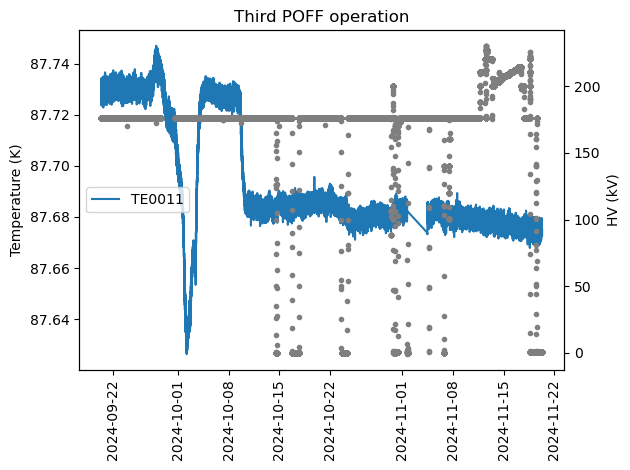

In [3]:
channel = "TE0011"
fig, axes = plt.subplots(1,1)
plt.xticks(rotation=90)
plt.title("Third POFF operation")
axes2 = axes.twinx()

conditions = (data[channel]<88.5)&(data[channel]>86)

axes.plot(data.loc[conditions].index.to_numpy(), data.loc[conditions][channel].to_numpy(), label=fr"{channel}")
# axes.axvline(datetime.datetime(2024, 11, 29, 23, 0, 0), color="red", label="CE OFF")
# axes.axvline(datetime.datetime(2024, 12, 2, 12, 0, 0), color="green", label="RECIRCULATION OFF")
# axes.axvline(datetime.datetime(2024, 12, 3, 14, 30, 0), color="orange", label="RECIRCULATION ON")
# axes.axvline(datetime.datetime(2024, 12, 3, 17, 32, 0), color="blue", label="CE ON")
axes.legend(loc="center left")
axes2.plot(data.index.to_numpy(), 1e-3*data["Heinz_VRaw"].to_numpy(), ".", color="tab:grey")
axes.set_ylabel("Temperature (K)")
axes2.set_ylabel("HV (kV)")
fig.tight_layout()
#fig.savefig("/eos/user/j/jcapotor/DUNE-IFIC/Experiments/ProtoDUNE-HD/Operation/Plots/second_poff/tevolution.png", format="png")
# data["TE0001"].loc[(data["TE0001"]<90)&(data["TE0001"]>87)].plot()
# data["Heinz_VRaw"].plot()

Text(0, 0.5, 'Temperature (mK)')

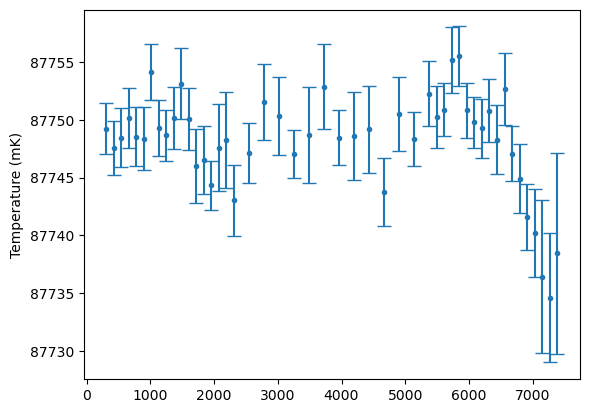

In [15]:
calib = utils.load_calib(
    path="/eos/user/j/jcapotor/RTDdata/calib/all/poff_2024-12-03 14:25:00.pkl"
    )["40525"]

date = datetime.datetime(2024, 5, 11, 12, 0, 0)
mapping = utils.load_mapping(date=date)

index = str(date)
row = data.loc[index]

tprofile = {}
fig, axes = plt.subplots(1,1)
for channel in row.index:
    mapping_row = mapping.loc[(mapping["SC-ID"]==channel)]
    system = mapping_row["SYSTEM"].values[0]
    if system != "TGRAD":
        continue
    try:
        sensor_id = str(int(mapping_row["CAL-ID"].iloc[0]))
    except:
        continue
    if sensor_id not in calib.index:
        continue
    tprofile[sensor_id] = {
        "temp":row[channel] - 1e-3*calib.loc[sensor_id]["cc"],
        "temp_err":(data_err.loc[index][channel] + 1e-3*calib.loc[sensor_id]["cc_err"]),
        "Y":mapping_row["Y"].iloc[0],
        "X":mapping_row["X"].iloc[0],
        "Z":mapping_row["Z"].iloc[0],
        "name":mapping_row["NAME"].iloc[0],
        }
tprofile = pd.DataFrame(tprofile).T
axes.errorbar(tprofile["Y"].to_numpy(), 1e3*(tprofile["temp"].to_numpy()), yerr=1e3*(tprofile["temp_err"]), fmt=".", capsize=5)
#axes.set_title(fr"{index}: HV={1e-3*row['Heinz_VRaw']:.0f} kV")
#axes.set_ylim(-40, 40)
axes.set_ylabel("Temperature (mK)")
#fig.savefig(fr"/eos/user/j/jcapotor/DUNE-IFIC/Experiments/ProtoDUNE-HD/Operation/Plots/HV_analysis/{index}: HV={1e-3*row['Heinz_VRaw']:.0f} kV.pdf", format="pdf")
#plt.close(fig)